In [1]:
import pandas
import os
import pixiedust

Pixiedust database opened successfully


# Look at our data

In [2]:
demographics = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_demographic.csv', delimiter="\t")
display(demographics)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,STD_STATUS,STD_GENDER,STD_LANGUAGE,STD_RELIGION,BIRTH_YEAR,DEATH_YEAR,IS_DECEASED,POSTAL_CODE_3,STD_ETHNICITY,STD_INSURANCE_TYPE,STD_RACE
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:05:23,1,1,eng,nan,1923,nan,False,631.0,non-hispanic,MEDICARE,101
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:23,1,1,eng,nan,1943,nan,False,157.0,declined,MEDICARE,101
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:05:23,1,2,eng,nan,1936,nan,False,170.0,declined,MEDICARE,101
00021CA6FF03E670,BILLING,00021CA6FF03E670,2016-03-03 19:05:23,1,1,eng,nan,1941,nan,False,800.0,non-hispanic,MEDICARE,615
00024B3D2352D2D0,BILLING,00024B3D2352D2D0,2016-03-03 19:05:23,1,1,eng,nan,1936,nan,False,544.0,non-hispanic,MEDICARE,101
0002DAE1C81CC70D,BILLING,0002DAE1C81CC70D,2016-03-03 19:05:23,1,1,eng,nan,1943,nan,False,110.0,non-hispanic,MEDICARE,203
0002F28CE057345B,BILLING,0002F28CE057345B,2016-03-03 19:05:23,1,1,eng,nan,1922,nan,False,170.0,non-hispanic,MEDICARE,101
000308435E3E5B76,BILLING,000308435E3E5B76,2016-03-03 19:05:23,1,1,eng,nan,1935,nan,False,556.0,hispanic,MEDICARE,101
000345A39D4157C9,BILLING,000345A39D4157C9,2016-03-03 19:05:23,1,2,eng,nan,1976,nan,False,481.0,non-hispanic,MEDICARE,101
00036A21B65B0206,BILLING,00036A21B65B0206,2016-03-03 19:05:23,1,2,eng,nan,1938,nan,False,350.0,non-hispanic,MEDICARE,203


In [3]:
histories = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_medical_history.csv', delimiter="\t")
display(histories)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,ENCOUNTER_RECORD_ID_HASH,ENCOUNTER_JOIN_ID,ICD_CODE,ICD_VERSION,STD_MEDICAL_HISTORY_DATE,CONTACT_DATE,SNOMED_IDS
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:26:33,542192281063886,542192281063886,V58.83,ICD9,2008-09-04 00:00:00,2008-09-04 00:00:00,"275917000,166938002,166943009"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,272.4,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,"55822004,13644009,238040008,234413005,3744001,238037008,238080004,238088006,238089003,299465007,445261005,426161002,402727002,402725005,402785008,402474007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,318.2,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,31216003
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,V58.69,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,"417284009,408536007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542272281166593,542272281166593,427.31,ICD9,2009-06-02 00:00:00,2009-06-02 00:00:00,49436004
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542282281644416,542282281644416,959.4,ICD9,2009-06-23 00:00:00,2009-06-23 00:00:00,"125599006,210574006,210575007,210585008,210588005,262971000,263264005,268117002,441886002,283809003,298080001,283568001,283567006,283566002,283202002,283160004,441885003,298081002,298082009,427914009,439052006,283161000"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:26:33,542282281644416,542282281644416,401.9,ICD9,2009-06-23 00:00:00,2009-06-23 00:00:00,59621000
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:26:33,542642281250669,542642281250669,564.09,ICD9,2009-10-11 00:00:00,2009-10-11 00:00:00,"236069009,163890000,430097009,432994008,31499008,197120000,21782001"
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:26:33,542642281250669,542642281250669,789.43,ICD9,2009-10-11 00:00:00,2009-10-11 00:00:00,438509009
0001FDD721E223DC,BILLING,0001FDD721E223DC,2016-03-03 19:26:33,542642281250669,542642281250669,V12.72,ICD9,2009-10-11 00:00:00,2009-10-11 00:00:00,429047008


In [4]:
diagnosis = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_diagnosis.csv', delimiter="\t")
display(diagnosis)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,DISORDER_CODE,ICD_CODE,ICD_VERSION,ENCOUNTER_JOIN_ID,ENCOUNTER_RECORD_ID,DIAGNOSIS_DATE,IS_PRINCIPAL,IS_ADMITTING,IS_REASON_FOR_VISIT,STATUS,CLAIM_TYPE,SNOMED_IDS
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:05:39,V58.83,V58.83,ICD9,542192281063886,542192281063886,2008-09-04 00:00:00,False,True,nan,Complete,PROFESSIONAL,"275917000,166938002,166943009"
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:05:39,V58.41,V58.41,ICD9,542192281063886,542192281063886,2008-09-04 00:00:00,True,False,nan,Complete,PROFESSIONAL,nan
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,V58.32,V58.32,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,True,False,nan,Complete,PROFESSIONAL,nan
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,V58.61,V58.61,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,nan
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,272.4,272.4,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,"55822004,13644009,238040008,234413005,3744001,238037008,238080004,238088006,238089003,299465007,445261005,426161002,402727002,402725005,402785008,402474007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,318.2,318.2,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,31216003
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,V58.69,V58.69,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,"417284009,408536007"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,427.31,427.31,ICD9,542272281166593,542272281166593,2009-06-02 00:00:00,False,False,nan,Complete,PROFESSIONAL,49436004
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,959.4,959.4,ICD9,542282281644416,542282281644416,2009-06-23 00:00:00,True,False,nan,Complete,PROFESSIONAL,"125599006,210574006,210575007,210585008,210588005,262971000,263264005,268117002,441886002,283809003,298080001,283568001,283567006,283566002,283202002,283160004,441885003,298081002,298082009,427914009,439052006,283161000"
00016F745862898F,BILLING,00016F745862898F,2016-03-03 19:05:39,E917.4,E917.4,ICD9,542282281644416,542282281644416,2009-06-23 00:00:00,False,False,nan,Complete,PROFESSIONAL,nan


In [5]:
observations = pandas.read_csv('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data/create_v_observation.csv', delimiter="\t")
display(observations)

EXPLORYS_PATIENT_ID,SOURCE_SYSTEM_TYPE,RECORD_ID_HASH,DATA_GRID_DATE_UPDATED,LOINC_TEST_ID,LOINC_CATEGORY_ID,STD_UOM,STD_VALUE,STD_VALUE_TXT,STD_REPORT_STATUS,STD_VALUE_STATUS,ENCOUNTER_RECORD_ID_HASH,ENCOUNTER_JOIN_ID,OBSERVATION_DATE,OBSERVATION_HIGH_REF,OBSERVATION_LOW_REF
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,5902-2,nan,nan,nan,nan,Ordered,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,29463-7,nan,kg,75.0,random generated weight,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8302-2,nan,cm,179.0,random generated height,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8310-5,nan,C,36.7,random generated body temp,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8462-4,nan,mmHg,59.0,random generated diastolic,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8480-6,nan,mmHg,139.0,random generated systolic,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,8867-4,nan,bpm,65.0,random generated heart rate,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,9279-1,nan,breaths/min,15.0,random generated resp rate,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,4548-4,nan,%,5.9,random generated HBA1C,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan
00013D2EFD8E45D1,BILLING,00013D2EFD8E45D1,2016-03-03 19:37:07,48643-1,nan,mLmin,133.0,random generated eGFR,Complete,nan,542192281063886,542192281063886,2008-09-04 00:00:00,nan,nan


# Make sure pixie app is installed

In [6]:
# Uncomment to install pixiedust_health from a local repository
# !pip install -e /Users/elizabethwells/PycharmProjects/WatsonHealth/pixiedust_health

In [8]:
from pixiedust_health import *
PixieHealthApp().run(runInDialog='true')

# Create Cohorts class

In [31]:
import os
from collections import defaultdict
from six import iteritems

# Hopefully find a better way to do this if we expand to other diseases
diseaseMap = {1: {'DisplayName': 'Diabetes', 'SnomedIds': ['44054006', '359642000','81531005','237599002','199230006','609567009','237627000',
                        '9859006','190331003','703138006','314903002','314904008','190390000','314772004',
                        '314902007','190389009','313436004','1481000119100'], 'loincIDs': [('HBA1C', '4548-4'), ('WEIGHT', '29463-7')]}, 2: {'DisplayName': 'Hypertension', 'SnomedIds': ['38341003']}}


# Class for storing data and generating DataFrames and matrices for UI and machine learning
# Requires 3 pandas data frames from create_v_demographic.csv, create_v_diagnosis.csv, and create_v_observation.csv
# Columns expected in demogaphics: 'EXPLORYS_PATIENT_ID', 'STD_GENDER', 'BIRTH_YEAR', 'STD_RACE'
# Columns expected in diagnosis: 'EXPLORYS_PATIENT_ID', 'DIAGNOSIS_DATE', 'SNOMED_IDS'
# Columns expected in observations: 'EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID', 'STD_VALUE'
class Cohorts:
    
    #--------------------------------------- PRIVATE METHODS ---------------------------------------#
    
    ##-------------------------------------- Initialization --------------------------------------##
    
#     def __init__(self, pathToData):
    def __init__(self, demographics, diagnosis, observations):
#         demographics = pandas.read_csv(pathToData + '/create_v_demographic.csv', delimiter="\t")
        print "demographics starting"
        self.demographics = self.__filterDemographics(demographics)
        print "demographics done"
        
#         diagnosis = pandas.read_csv(pathToData + '/create_v_diagnosis.csv', delimiter="\t")
        print "histories starting"
        self.histories = self.__filterDiagnosis(diagnosis)
#         self.diagnosis = self.__filterDiagnosis(diagnosis)
#         self.histories, self.diagnosis = self.__filterDiagnosis(diagnosis)
        print "histories done"
        
#         observations = pandas.read_csv(pathToData + '/create_v_observation.csv', delimiter="\t")
        print "observations starting"
        self.observations = observations
        self.demographics = self.__getFeatures(observations)
        print "observations done"
        
    # Returns filtered demographics data frame
    # Requires original demographics chart
    # Used in initial processing of data
    def __filterDemographics(self, demographics):
        filteredDemographics = demographics[['EXPLORYS_PATIENT_ID', 'STD_GENDER', 'BIRTH_YEAR', 'STD_RACE']]
        ages = filteredDemographics['BIRTH_YEAR'].map(lambda x: 2017 - int(x))
        filteredDemographics['AGE'] = ages.values
        return filteredDemographics.drop('BIRTH_YEAR', 1)
    
    # Returns diagnosis history data frame
    # Requires original diagnosis histories chart
    # Used in initial processing of data
    def __filterDiagnosis(self, histories):
        filteredHistories = histories[['EXPLORYS_PATIENT_ID', 'DIAGNOSIS_DATE', 'SNOMED_IDS']]
        snomedIDs = filteredHistories['SNOMED_IDS'].map(lambda x: tuple(x.split(',')) if isinstance(x, str) else tuple())
        filteredHistories['SNOMED_IDS'] = snomedIDs.values
        return filteredHistories
       
    # Returns the BMI of a patient given their information in demographics
    # Designed to be used in the apply function in getFeatures()
    def __bmi(self, row):
        return (row['WEIGHT'] / row['HEIGHT']**2) * 10000
    
    # Returns filtered observation data frame
    # Requires original observations chart
    # Used in initial processing of data
    def __getFeatures(self, observations):
        demographicCopy = self.demographics
        filteredObservations = observations[['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID', 'STD_VALUE']]
        filteredObservations = filteredObservations.groupby(['EXPLORYS_PATIENT_ID', 'LOINC_TEST_ID'], as_index=False).mean()
        loincIDs = [('HBA1C', '4548-4'), ('WEIGHT', '29463-7'), ('HEIGHT', '8302-2')]
        for label, loinc in loincIDs:
            justThisLabel = filteredObservations.loc[filteredObservations['LOINC_TEST_ID'] == loinc]
            justThisLabel = justThisLabel.rename(columns={'STD_VALUE': label})
            demographicCopy = demographicCopy.merge(justThisLabel.drop('LOINC_TEST_ID', 1))
        bmis = demographicCopy[['WEIGHT', 'HEIGHT']].apply(self.__bmi, axis=1)
        demographicCopy['BMI'] = bmis.values
        return demographicCopy
    
    ##------------------------ Utility functions for filtering by disease ------------------------##
    
    # Returns a list of all patients we have a medical history for
    # Facilitates getPatientsWithoutDisease()
    def __getPatients(self):
        return set(self.histories['EXPLORYS_PATIENT_ID'].values)
    
        # Returns list of IDs for patients with a given disease
    # Requires disease ID
    # Facilitates getDemographics() and used in machine learning component
    def __getPatientsWithDisease(self, diseaseID):
        snomedIDs = diseaseMap[diseaseID]['SnomedIds']
        filtered = self.histories.loc[[not (set(history).isdisjoint(snomedIDs)) for history in self.histories['SNOMED_IDS']]]
        return set(filtered['EXPLORYS_PATIENT_ID'].values)
    
    # Returns list of IDs for patients without a given disease
    # Requires disease ID
    # Facilitates getDemographics() and used in machine learning component
    def __getPatientsWithoutDisease(self, diseaseID):
        return self.__getPatients() - self.__getPatientsWithDisease(diseaseID)
    
    #--------------------------------------- PUBLIC METHODS ---------------------------------------#
    
    # Returns list of (DisplayName, ID) for all diseases we have data for
    # Designed for drop-down menu in initial window of UI
    # Example return: [('Diabetes', 1), ('Hypertension', 2)]
    def getDiseases(self):
        return [(value['DisplayName'], key) for key, value in iteritems(diseaseMap)]
    
    # Returns a dictionary of Data Frames, one for demographics and stats for patients with the given disease (key 'pos') 
    #   and one for patients who don't have that disease (key 'neg')
    # Columns in returned data frames: 'EXPLORYS_PATIENT_ID', 'STD_GENDER', 'STD_RACE', 'AGE', 'HBA1C', 'WEIGHT', 'HEIGHT', 'BMI'
    # Had to calculate age  from birth year and BMI from weight and height
    # Designed for descriptive analytics window of UI and to use in getFeatureVectors()
    # This part is split into 2 separate data frames so the information shown in the pixieapp is just the people with the disease
    def getDemographics(self, diseaseID):
        pos_patients = self.__getPatientsWithoutDisease(diseaseID)
        neg_patients = self.__getPatientsWithDisease(diseaseID)
        pos_demographics = self.demographics.loc[self.demographics['EXPLORYS_PATIENT_ID'].isin(pos_patients)]
        neg_demographics = self.demographics.loc[self.demographics['EXPLORYS_PATIENT_ID'].isin(neg_patients)]
        return {'pos': pos_demographics, 'neg': neg_demographics}
    
    # Returns a data frame including both patients with and without given disease
    # HAS_DISEASE column indicates whether a patient has the disease or not
    # Returns only certain features if features are specified
    # Columns returned by default: 'STD_GENDER', 'STD_RACE', 'AGE', 'HBA1C', 'WEIGHT', 'HEIGHT', 'BMI', 'HAS_DISEASE'
    # Features argument must be some subset of the default columns
    # Out of the positive and negative patients, the bigger group is cut down to be the same size as the smaller group
    # Used in machine learning component
    def getFeatureVectors(self, diseaseID, features=None):
        dataFrames = self.getDemographics(diseaseID)
        size = min(len(dataFrames['pos'].index), len(dataFrames['neg'].index))
        for k in dataFrames:
            dataFrames[k] = dataFrames[k].drop('EXPLORYS_PATIENT_ID', 1)
            dataFrames[k] = dataFrames[k][:size]
            if features:
                dataFrames[k] = dataFrames[k][features]
            dataFrames[k]['HAS_DISEASE'] = k
        return pandas.concat([dataFrames['pos'], dataFrames['neg']])
        

# Create instance of Cohorts and Test

In [32]:
cohorts = Cohorts(demographics, diagnosis, observations)

demographics starting
demographics done
histories starting


/Users/elizabethwells/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/elizabethwells/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


histories done
observations starting
observations done


### Page 0: Dropdown menu

In [33]:
# from pixiedust_health.cohort import *
# cohorts = Cohorts('/Users/elizabethwells/PycharmProjects/WatsonHealth/synthetic_data')
cohorts.getDiseases()

[('Diabetes', 1), ('Hypertension', 2)]

### Page 1: Descriptive Analytics / Charts


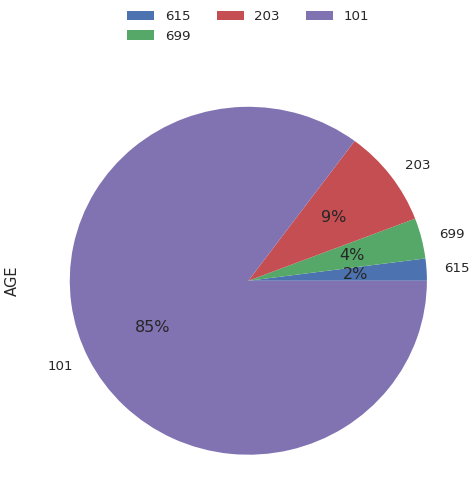

In [29]:
demographicDF = cohorts.getDemographics(1)['pos']
display(demographicDF)


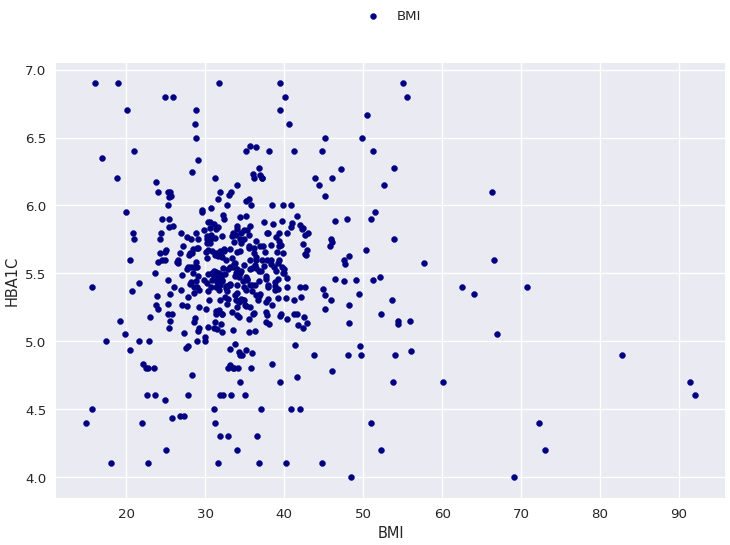

In [15]:
display(demographicDF)


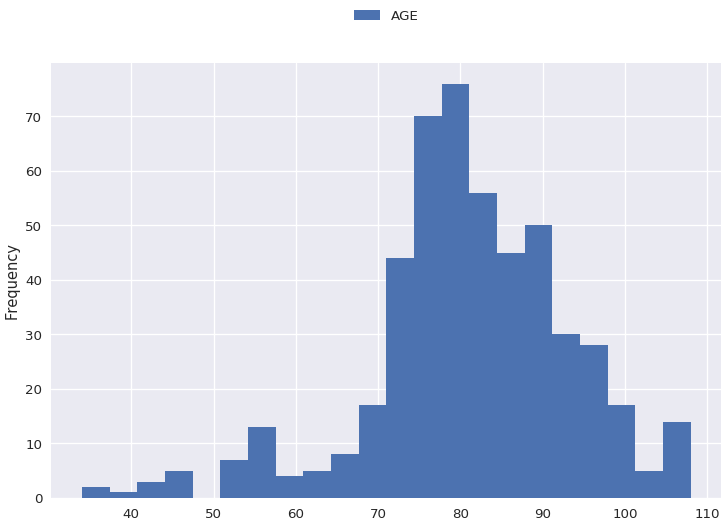

In [16]:
display(demographicDF)


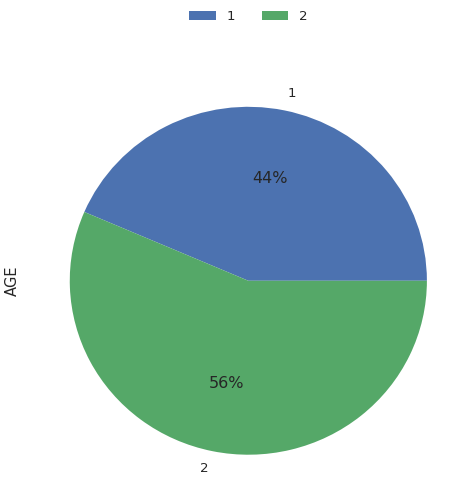

In [17]:
display(demographicDF)

### Page 2: Classsification Model

In [34]:
display(cohorts.getFeatureVectors(1))

STD_GENDER,STD_RACE,AGE,HBA1C,WEIGHT,HEIGHT,BMI,HAS_DISEASE
1,101,94,6.05,74.0,174.5,24.3019351237,pos
1,101,74,6.0,74.6666666667,158.5,29.7213293661,pos
1,101,81,5.8,81.0,188.0,22.9176097782,pos
1,101,82,5.21176470588,74.8823529412,154.647058824,31.310943378,pos
2,101,83,4.7,65.0,195.0,17.094017094,pos
2,101,81,5.55,76.75,154.75,32.0491908101,pos
1,101,52,5.41333333333,69.6666666667,158.133333333,27.8598119147,pos
1,101,79,6.3,87.0,146.0,40.8144117095,pos
2,101,75,6.3,80.0,151.0,35.0861804307,pos
2,101,106,5.74736842105,77.3684210526,146.0,36.2959378179,pos


In [35]:
display(cohorts.getFeatureVectors(2, ['AGE', 'BMI']))

AGE,BMI,HAS_DISEASE
94,24.3019351237,pos
74,29.7213293661,pos
81,22.9176097782,pos
95,38.5300044188,pos
82,31.310943378,pos
83,17.094017094,pos
88,30.6725416697,pos
81,44.6397433215,pos
83,28.3990457295,pos
81,32.0491908101,pos
